# **Apple-Twitter-Sentiment-Analysis**

##  **Project Introduction: Apple Twitter Sentiment Analysis**

This project aims to classify sentiments in tweets mentioning **Apple Inc.** into three categories: **positive**, **neutral**, or **negative**. Sentiment analysis is a key application of natural language processing (NLP) that helps organizations understand public opinion at scale.

We use a labeled dataset of tweets annotated with sentiment categories and confidence scores. By building a machine learning model to classify these tweets automatically, we aim to enable scalable monitoring of public sentiment related to Apple’s brand and products.

This project follows the **CRISP-DM (Cross-Industry Standard Process for Data Mining)** methodology, which provides a structured and iterative framework for carrying out data science projects effectively.

---

##  **Business Understanding**

Understanding customer and public sentiment is crucial for brand management, competitive analysis, and decision-making. In this case, we are interested in automating the detection of sentiment in social media posts about **Apple Inc.**.

Manually labeling tweets is both time-consuming and prone to inconsistency. Automating this process allows:
- **Real-time insights** into how people perceive Apple products, services, and announcements.
- **Trend monitoring** around events such as product launches or controversies.
- **Actionable intelligence** for marketing, public relations, and strategic planning.

##  **Objectives**

The main objectives of this project are:

- To preprocess the tweet data using **Natural Language Processing (NLP)** techniques.
- To perform **Exploratory Data Analysis (EDA)** on the text to understand word patterns, frequency, and sentiment distribution.
- To build a **machine learning classifier** that accurately predicts the sentiment of tweets.
- To evaluate the performance of different classifiers using appropriate **classification metrics** such as accuracy, precision, recall, and F1-score.


This system could later be extended for real-time social media tracking or integrated into customer feedback pipelines.



## **Data Understanding**

The dataset used in this project is the **Apple Twitter Sentiment DFE** dataset from data world. It contains tweets labeled with sentiment classes and additional metadata. Here's a high-level overview of the dataset:

###  Key Columns:
- `text`: The tweet content (our main feature for analysis).
- `sentiment`: The sentiment label assigned to each tweet (our target variable).
- `sentiment:confidence`: A score indicating how confident the annotator or system was in the assigned label.

###  Observations from Initial Exploration:
- The dataset contains **3886 rows** and several metadata columns (e.g., unit ID, query, annotation state) which are not relevant for sentiment modeling and will be dropped during preprocessing.
- The `sentiment` column contains some **non-numeric and noisy values** (e.g., `not_relevant`, or merged label codes like `3\n1`) that must be cleaned or filtered out.
- The `text` column contains **raw social media content**, including mentions, hashtags, links, and special characters that will need to be cleaned for modeling.
- The `sentiment:confidence` column varies in range and may be used to **filter out low-confidence annotations** to improve model quality.

This understanding will guide our **data cleaning and feature engineering** efforts in the next stages of the project.



## **1. Data Preparation**

### **Importing Dependencies**

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("punkt_tab")
nltk.download("wordnet")
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Loading Data**

We load the Apple Twitter Sentiment dataset from a CSV file using `pandas.read_csv`. Since the file contains special characters, we specify the encoding as `ISO-8859-1`.

In [2]:
# loading the dataset
df=pd.read_csv("Apple-Twitter-Sentiment-DFE.csv",encoding="ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL






The dataset contains various metadata columns related to tweet annotations as well as the actual tweet text and sentiment labels.


### **Extracting relevant columns**

From the loaded dataset, we extract only the columns that are directly relevant for sentiment analysis:

- `sentiment`: the label or target variable
- `sentiment:confidence`: confidence score of the assigned label
- `text`: the actual tweet text we want to analyze

This step simplifies our dataset to only what's necessary for modeling and text preprocessing.


In [3]:
# extracting the relevant columns
df_rel=df[["sentiment","sentiment:confidence","text"]]
df_rel.head()

,sentiment,sentiment:confidence,text
0,3,0.6264,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,3,0.8129,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,3,1.0000,My cat only chews @apple cords. Such an #Apple...
3,3,0.5848,I agree with @jimcramer that the #IndividualIn...
4,3,0.6474,Nobody expects the Spanish Inquisition #AAPL


### **Renaming Columns**


Here, we rename the column `sentiment:confidence` to `sentiment confidence` for easier access and improved readability in our analysis and model-building code.


In [4]:
# renaming the sentiment:confidence column
df_rel=df_rel.rename(columns={"sentiment:confidence":"sentiment confidence"})

### **Dataset Summary**

In this step, we examine a concise summary of the dataset.

In [5]:
# summary of the dataset
df_rel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentiment             3886 non-null   object 
 1   sentiment confidence  3886 non-null   float64
 2   text                  3886 non-null   object 
dtypes: float64(1), object(2)
memory usage: 91.2+ KB



 It contains 3 columns and 3,886 entries. The `sentiment` and `sentiment confidence` columns are currently stored as object types, suggesting the need for further inspection and possible data type conversion before modeling.


Next we inspect the value counts of two key columns:
- `sentiment`: to see how many tweets fall into each label category
- `sentiment confidence`: to examine the spread of confidence scores assigned during annotation

This step helps us identify possible anomalies like unexpected labels (e.g., `not_relevant`) and decide on thresholding for label quality based on confidence.


In [6]:
col_check=["sentiment","sentiment confidence"]
for col in col_check:
    print(df_rel[col].value_counts())

sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64
sentiment confidence
1.0000    1899
0.6722      46
0.6884      32
0.6825      29
0.6635      27
          ... 
0.8578       1
0.4882       1
0.6490       1
0.6686       1
0.9230       1
Name: count, Length: 654, dtype: int64


### **Casting Columns**



This cell ensures that the `sentiment` and `sentiment confidence` columns are properly converted to numeric values using `pd.to_numeric`.

We use `errors='coerce'` to handle invalid entries (e.g., text labels like `'not_relevant'`) by converting them to `NaN`.

After conversion, we call `.info()` again to verify the changes and identify any new missing values introduced during the coercion.


In [7]:
# casting 'sentiment' and 'sentiment confidence' column values to integers
df_rel["sentiment confidence"] = pd.to_numeric(df_rel["sentiment confidence"], errors='coerce')
df_rel["sentiment"] = pd.to_numeric(df_rel["sentiment"], errors='coerce')
df_rel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentiment             3804 non-null   float64
 1   sentiment confidence  3886 non-null   float64
 2   text                  3886 non-null   object 
dtypes: float64(2), object(1)
memory usage: 91.2+ KB


### **Handling Null and Duplicate Values**

Here we define a reusable function called `clean(df)` to perform essential dataset cleaning:
- Display the number of missing values (`NaN`)
- Drop rows with missing values
- Display the number of duplicate rows
- Remove duplicate rows

The cleaned DataFrame is returned for further use in model development.


In [8]:
# creating a function to clean the dataset
def clean(df):
    print(f"null : {df.isna().sum()}")
    df=df.dropna()
    print(f"is duplicated : {df.duplicated().sum()}")
    df=df.drop_duplicates()
    return df
    

In [9]:
# utilizing the clean function
df_clean=clean(df_rel)
df_clean.info()

null : sentiment               82
sentiment confidence     0
text                     0
dtype: int64
is duplicated : 382
<class 'pandas.core.frame.DataFrame'>
Index: 3422 entries, 0 to 3885
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentiment             3422 non-null   float64
 1   sentiment confidence  3422 non-null   float64
 2   text                  3422 non-null   object 
dtypes: float64(2), object(1)
memory usage: 106.9+ KB


###  **Text preprocessing**

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

- Lower Casing: Each text is converted to lowercase.
- Replacing URLs: Links starting with "http" or "https" or "www" are replaced by space.
- Replacing Usernames: Replace @Usernames with space
- Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
- Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
- Removing Short Words: Words with length less than 2 are removed.
- Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
- Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [10]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

def preprocess_tweets(series):
    wordLemm = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Regex patterns
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    def clean_tweet(tweet):
        tweet = str(tweet).lower()
        tweet = re.sub(urlPattern, ' ', tweet)
        tweet = re.sub(userPattern, ' ', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        words = []
        for word in tweet.split():
            if word not in stop_words and len(word) > 1:
                word = wordLemm.lemmatize(word)
                words.append(word)
        return " ".join(words)

    return series.apply(clean_tweet)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df_clean['processed'] = preprocess_tweets(df_clean['text'])  

In [12]:
df_clean

,sentiment,sentiment confidence,text,processed
0,3.0,0.6264,#AAPL:The 10 best Steve Jobs emails ever...htt...,aapl best steve job email ever
1,3.0,0.8129,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,rt aapl stock mini flash crash today aapl aapl
2,3.0,1.0000,My cat only chews @apple cords. Such an #Apple...,cat chew cord applesnob
3,3.0,0.5848,I agree with @jimcramer that the #IndividualIn...,agree individualinvestor trade apple aapl exte...
4,3.0,0.6474,Nobody expects the Spanish Inquisition #AAPL,nobody expects spanish inquisition aapl
...,...,...,...,...
3881,3.0,0.7757,(Via FC) Apple Is Warming Up To Social Media -...,via fc apple warming social medium apple hirin...
3882,3.0,0.6225,RT @MMLXIV: there is no avocado emoji may I as...,rt avocado emoji may ask
3883,5.0,0.9347,@marcbulandr I could not agree more. Between @...,could agree great thing happen appleandibm ibm...
3884,1.0,0.9230,My iPhone 5's photos are no longer downloading...,iphone photo longer downloading automatically ...


### **Feature Engineering**

To enhance our understanding of the dataset, we create additional columns that capture the number of characters, sentences, and words in each text entry. These new features will allow us to explore the structural properties of the text and may provide useful signals for downstream analysis or modeling.

In [13]:
# creating columns for number of characters, number of sentences and number of words
df_clean["char"]=df_clean["text"].apply(lambda x:len(x))
df_clean["words"]=df_clean["text"].apply(lambda x:nltk.word_tokenize(x)).apply(lambda x:len(x))
df_clean["sentences"]=df_clean["text"].apply(lambda x:nltk.sent_tokenize(x)).apply(lambda x:len(x))
df_clean.sample(10)

,sentiment,sentiment confidence,text,processed,char,words,sentences
2292,1.0,1.0000,Safari just crashed on me and I didn't have an...,safari crashed tab open wtf,68,16,1
354,3.0,1.0000,@Archimage @Apple seen a bunch of people tweet...,seen bunch people tweeting search twitter dev ...,116,25,3
21,3.0,0.7244,The JH Hines Staff with their newly issued @ap...,jh hines staff newly issued connected macbook ...,111,21,1
3374,1.0,0.7651,I just got this charger like 2 weeks ago what ...,got charger like week ago frick,62,14,1
2418,1.0,0.6672,@briankardell @jacobrossi @Apple Apparently ev...,apparently even info bug going fixed must kept...,139,33,2
2082,5.0,0.6631,@APSVirginia special education staff working h...,special education staff working hard behalf st...,130,20,1
2867,3.0,1.0000,@apple I wish camera on the side in next #iPho...,wish camera side next iphone landscapetwitter ...,104,26,2
536,3.0,0.7011,I'm learning all about iPod Touch at @Influens...,learning ipod touch,80,16,2
589,1.0,0.7039,@anneohirsch @Apple My 5S was great - just had...,great cracked screen amp dying battery thinkin...,138,35,2
829,3.0,0.6647,@jakeflem @Apple take it in. that's a faulty g...,take faulty graphic card recalled exact prob r...,140,32,3


## **2. Exploratory Data Analysis**

In this section, we visually explore the dataset using bar plots and box plots to better understand the distribution of variables, detect outliers, and uncover patterns or trends that may influence model performance.


To improve clarity and interpretability, we rename the values in the **sentiment** column. This makes the labels more descriptive and easier to understand during analysis and visualization.


In [14]:
# renaming the sentiment column values
df_clean["sentiment"]=df_clean["sentiment"].replace({1.0:"Negative",3.0:"Neutral",5.0:"positive"})

### **checking for the spread of sentiments**


To understand the distribution of our target classes, we plot a count plot. This visualization helps us identify any class imbalances that may exist in the dataset.


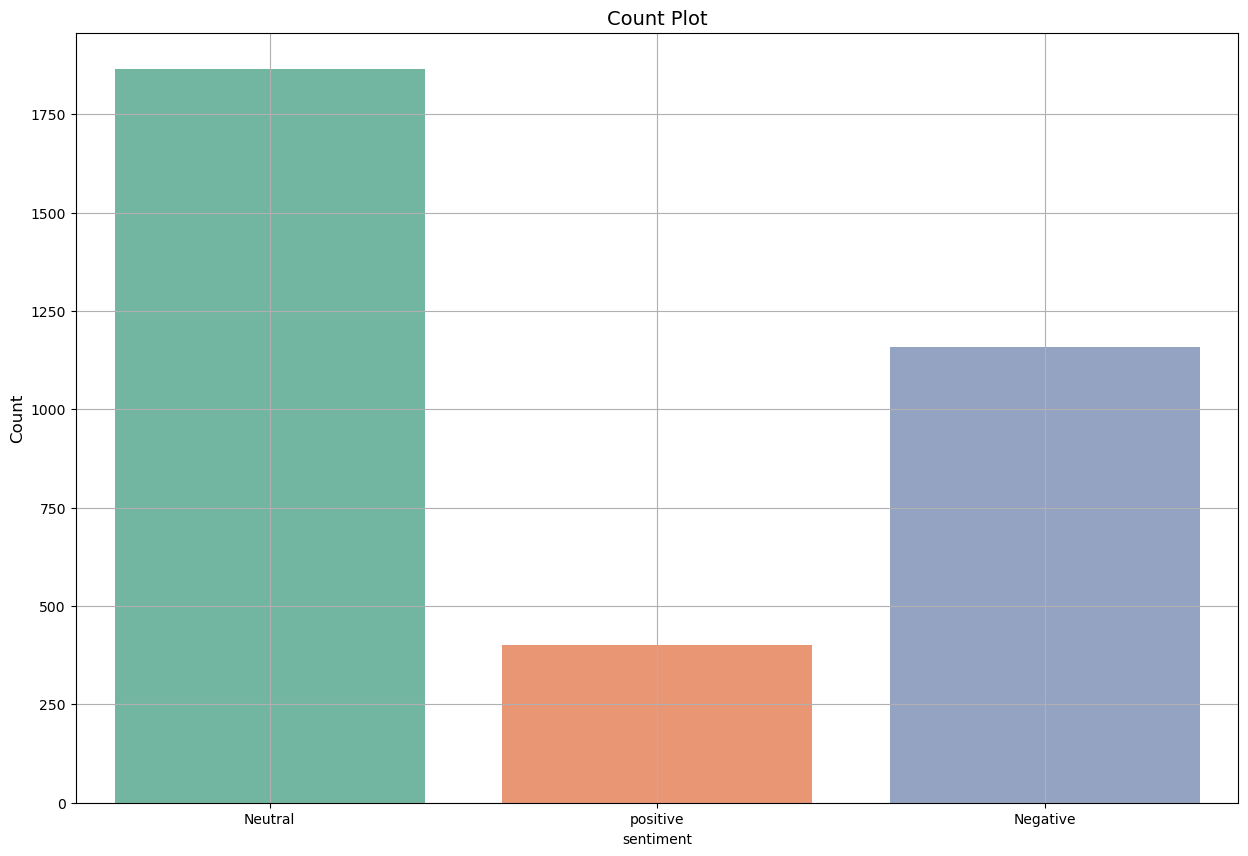

In [15]:
# importing Plot class
from kev_plot import Plot
# initializing the class
plot=Plot()
plot.countplot(data=df_clean,x="sentiment")

The count plot illustrates the distribution of tweets across three sentiment categories: neutral, positive, and negative. From the chart, it is evident that neutral tweets are the most frequent, significantly outnumbering the other two classes. Negative tweets follow, indicating that a considerable portion of the tweets express dissatisfaction or criticism. On the other hand, positive tweets are the least represented in the dataset.

This imbalance in the sentiment classes suggests that the dataset is not evenly distributed, which could have implications for any machine learning models trained on this data. For example, models might become biased toward predicting the majority class (neutral sentiment) unless appropriate measures—such as class weighting or resampling—are taken during preprocessing.

Understanding this distribution is an important first step in preparing the data for analysis, as it highlights the need for careful handling of class imbalance to ensure accurate and fair predictions across all sentiment categories.

### **Data Description**

In [16]:
df_clean.describe()

,sentiment confidence,char,words,sentences
count,3422.000000,3422.000000,3422.000000,3422.000000
mean,0.831134,99.542665,20.823787,1.598480
std,0.175389,32.461059,7.230791,0.838337
min,0.332700,11.000000,3.000000,1.000000
25%,0.674925,77.000000,16.000000,1.000000
50%,0.853900,102.000000,21.000000,1.000000
75%,1.000000,130.000000,27.000000,2.000000
max,1.000000,148.000000,40.000000,7.000000


he table above presents summary statistics for four key columns: **sentiment confidence**, **char**, **words**, and **sentences** — calculated from 3,422 tweets after cleaning.

- **Sentiment Confidence**: This column represents the model’s confidence in assigning sentiment labels. The mean confidence score is approximately **0.83**, with a minimum of **0.33** and a maximum of **1.00**. The high median (0.85) and 75th percentile (1.00) suggest that most predictions were made with strong confidence. However, the standard deviation of **0.17** indicates some variability in certainty, likely due to ambiguous or neutral tweets.

- **Char (Characters)**: On average, tweets contain **about 100 characters**, with lengths ranging from **11** to **148** characters. The spread (std ≈ 32.46) suggests a moderate variation in tweet length, consistent with Twitter's character limits and user writing styles.

- **Words**: Each tweet has an average of **21 words**, with a minimum of **3** and a maximum of **40**. The median word count is **21**, closely aligning with the mean, indicating a fairly symmetric distribution. Most tweets fall between **16 (25%) and 27 (75%)** words, with relatively few very short or very long entries.

- **Sentences**: Most tweets are concise, with an average of **1.6 sentences**. The data shows that 50% of tweets contain only **1 sentence**, and 75% contain no more than **2 sentences**. The maximum is **7**, which likely reflects a few unusually long or punctuated tweets. The small standard deviation (**0.83**) confirms that sentence count is generally low and consistent.

Overall, these statistics confirm that the dataset contains **compact, mostly single-sentence tweets**, with **high sentiment confidence scores** and consistent length in terms of characters and words. This provides a solid foundation for further Natural Language Processing (NLP) tasks like classification or visualization.

### **box plot of the distribution of number of characters accross classes**

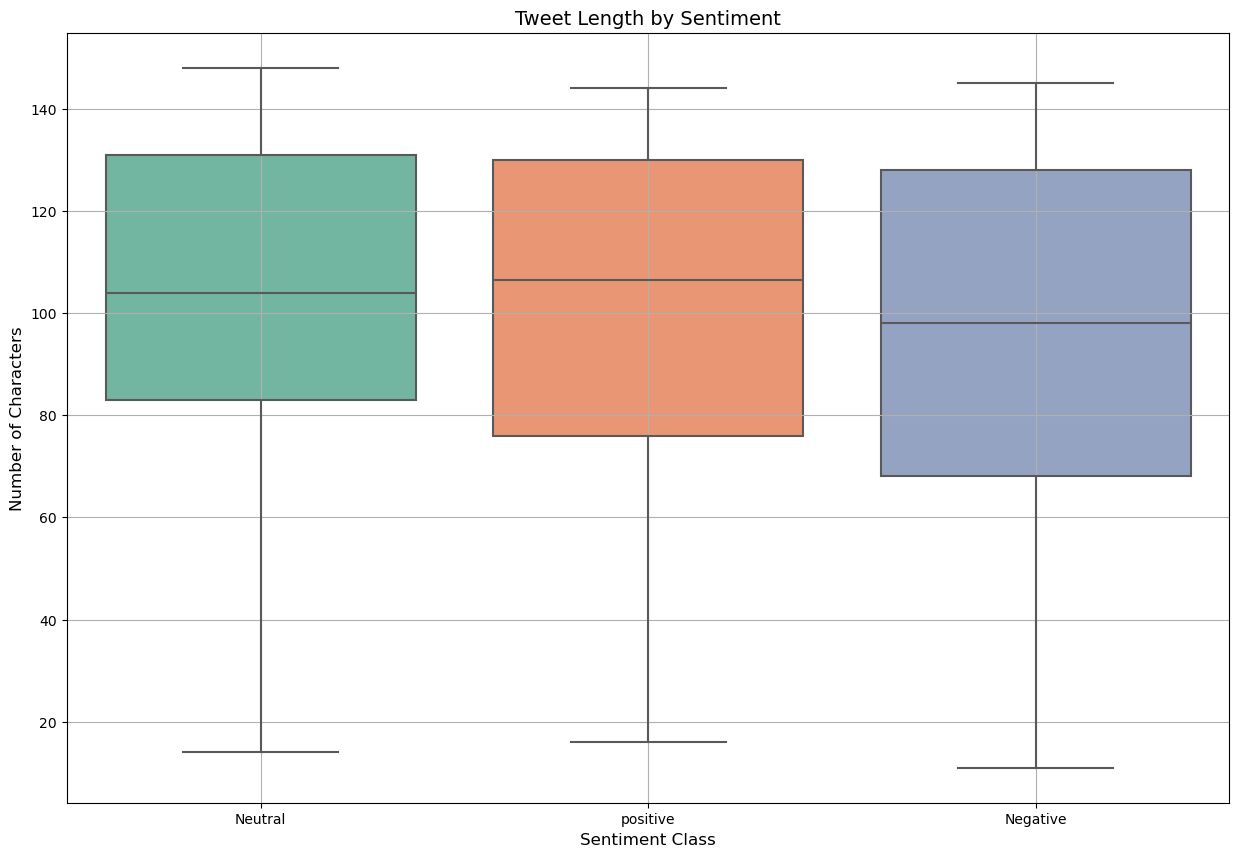

In [17]:
plot.boxplot(
    data=df_clean,
    x='sentiment',                # Categorical variable on the x-axis
    y='char',              # Numeric variable to plot
    title='Tweet Length by Sentiment',
    xlabel='Sentiment Class',
    ylabel='Number of Characters')

The boxplot illustrates how tweet lengths, measured by the number of characters, are distributed across three sentiment categories: Neutral, Positive, and Negative.

Across all three classes, the median tweet length is relatively similar, though positive tweets appear to be slightly longer on average. The interquartile range (IQR)—which shows the middle 50% of tweet lengths—is broader for neutral and positive tweets, indicating greater variability in how long those tweets tend to be. In contrast, negative tweets show a slightly narrower range, suggesting more consistency in their length.

There are also outliers present in all three sentiment categories. These represent tweets that are either very short or unusually long, possibly reflecting highly condensed messages or those that approach the character limit of the platform.

In general, neutral and positive tweets tend to be longer than negative ones, though the overall character count range is similar across all sentiments. This distribution is valuable when exploring how sentiment correlates with tweet length and can serve as a useful feature during text preprocessing or model development for sentiment classification.

### **box plot of the distribution of number of words accross classes**

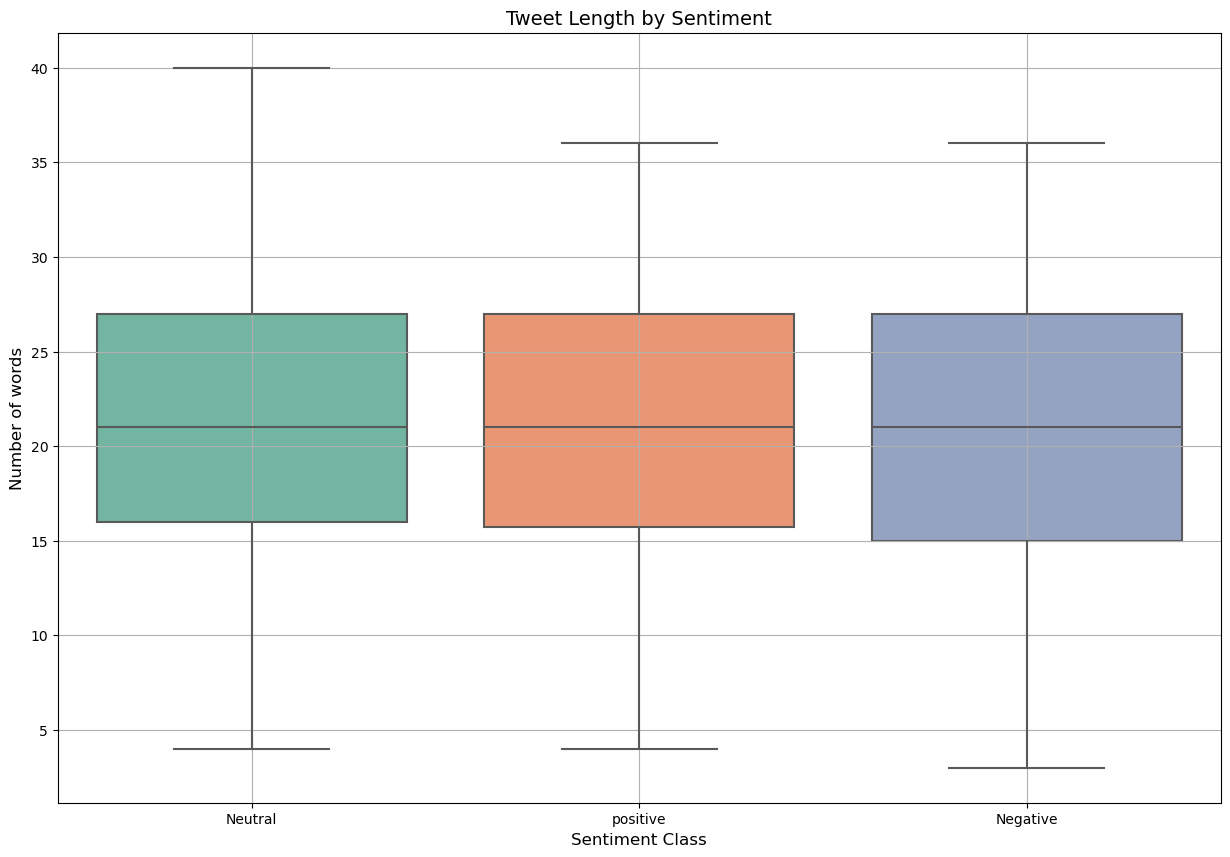

In [18]:
plot.boxplot(
    data=df_clean,
    x='sentiment',                # Categorical variable on the x-axis
    y='words',              # Numeric variable to plot
    title='Tweet Length by Sentiment',
    xlabel='Sentiment Class',
    ylabel='Number of words')

The boxplot shows how tweet lengths, measured by the number of words, are distributed across the three sentiment categories: Neutral, Positive, and Negative.

Across all sentiment classes, the median word count is consistent, averaging around 21 words per tweet. This suggests that, regardless of the emotional tone, users tend to express their thoughts using a similar number of words. The interquartile range (IQR)—which represents the middle 50% of tweets—falls between 15 and 27 words for each sentiment, indicating a comparable spread in word usage.

While most tweets cluster within this range, there are a few outliers in each class. Some tweets are as short as 3 words, while others reach up to 40 words, reflecting occasional extremes in tweet length. However, these are exceptions rather than the norm.

Overall, the distribution of word counts is highly uniform across neutral, positive, and negative tweets. This implies that although the content or tone of a message may change with sentiment, the amount of words used does not vary significantly. This finding can be useful in natural language processing tasks, especially during text preprocessing or normalization, where consistent word length helps simplify modeling and analysis.

### **box plot of the distribution of number of sentences accross classes**

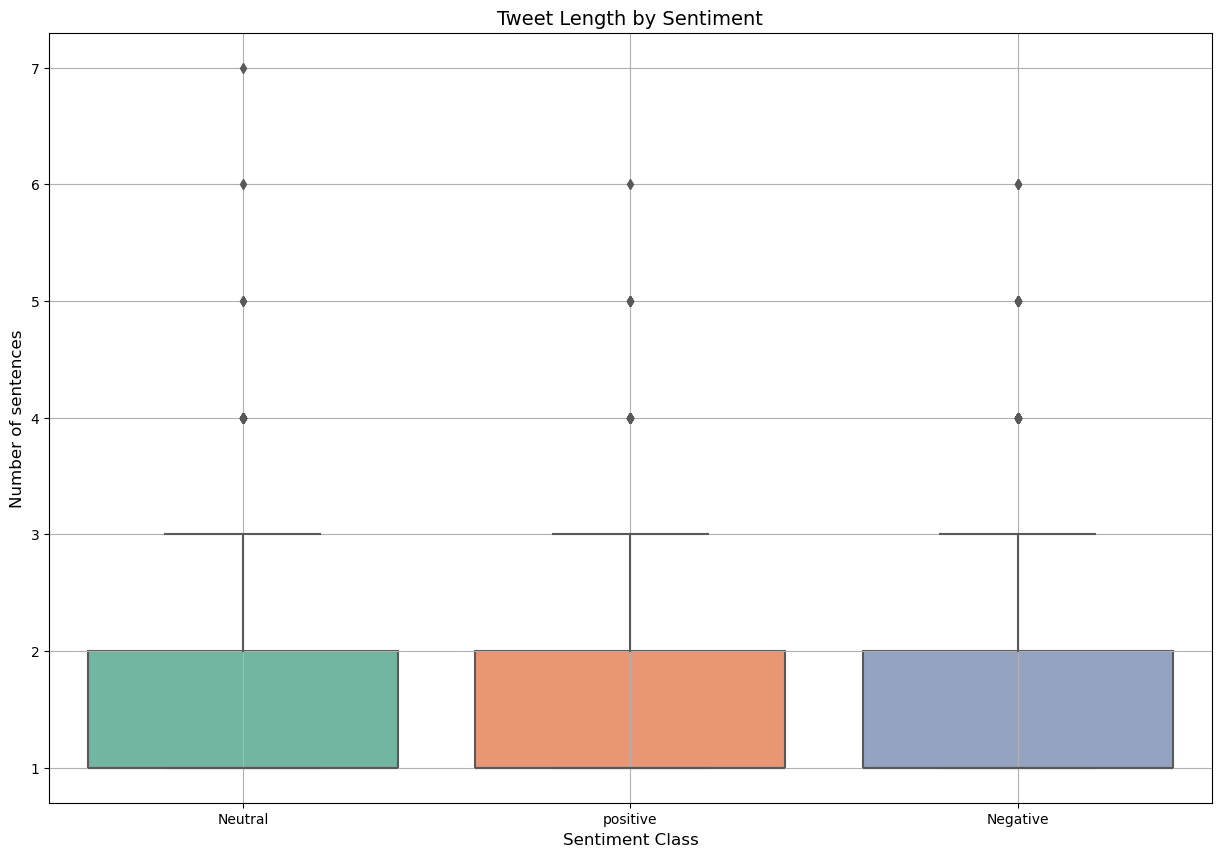

In [19]:
plot.boxplot(
    data=df_clean,
    x='sentiment',                # Categorical variable on the x-axis
    y='sentences',              # Numeric variable to plot
    title='Tweet Length by Sentiment',
    xlabel='Sentiment Class',
    ylabel='Number of sentences')

The boxplot illustrates the distribution of tweet lengths, measured by the number of sentences, across three sentiment categories: Neutral, Positive, and Negative.

Across all sentiment types, tweet lengths are remarkably consistent. The vast majority of tweets contain just one or two sentences, indicating a strong preference for brevity regardless of emotional tone. The median length is one sentence for all sentiment categories, further reinforcing the idea that tweets are typically short and concise.

While most tweets are brief, there are a few exceptions. Some tweets extend to six or seven sentences, appearing as outliers in the data. These longer entries may reflect more detailed messages, discussions, or storytelling, though they are relatively rare.

Overall, the distribution shows no significant variation in sentence length between the different sentiment classes. This suggests that the number of sentences used in a tweet does not depend on whether its tone is neutral, positive, or negative. The findings emphasize the inherently compact nature of tweets, which generally maintain a consistent structure across emotional expressions.

### **Bar plot of top words per class**

We need to **plot the top words for each class** to better understand the nature and distribution of words within each category. This will help us identify patterns or dominant terms that may influence classification.

In [20]:
# defining the plot funtion
from collections import Counter
def plot_top_words_by_sentiment(df, text_col='lemmas', sentiment_col='sentiment', top_n=10, figsize=(15, 10)):
    """
    Plots bar charts of the top N most common words for each sentiment class.

    Parameters:
    - df: DataFrame containing the text and sentiment
    - text_col: name of the column containing cleaned text
    - sentiment_col: name of the column containing sentiment labels
    - top_n: number of top words to show per sentiment
    - figsize: figure size for each subplot
    """
    sentiments = df[sentiment_col].unique()
    n_classes = len(sentiments)

    fig, axes = plt.subplots(1, n_classes, figsize=figsize)

    if n_classes == 1:
        axes = [axes]  # make axes iterable

    for ax, sentiment in zip(axes, sentiments):
        # Filter by sentiment
        texts = df[df[sentiment_col] == sentiment][text_col]
        all_words = " ".join(texts).split()
        
        # Count words
        word_counts = Counter(all_words).most_common(top_n)
        words, counts = zip(*word_counts)

        # Plot
        ax.barh(words[::-1], counts[::-1], color='skyblue')
        ax.set_title(f"Top {top_n} Words\n({sentiment})", fontsize=14)
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

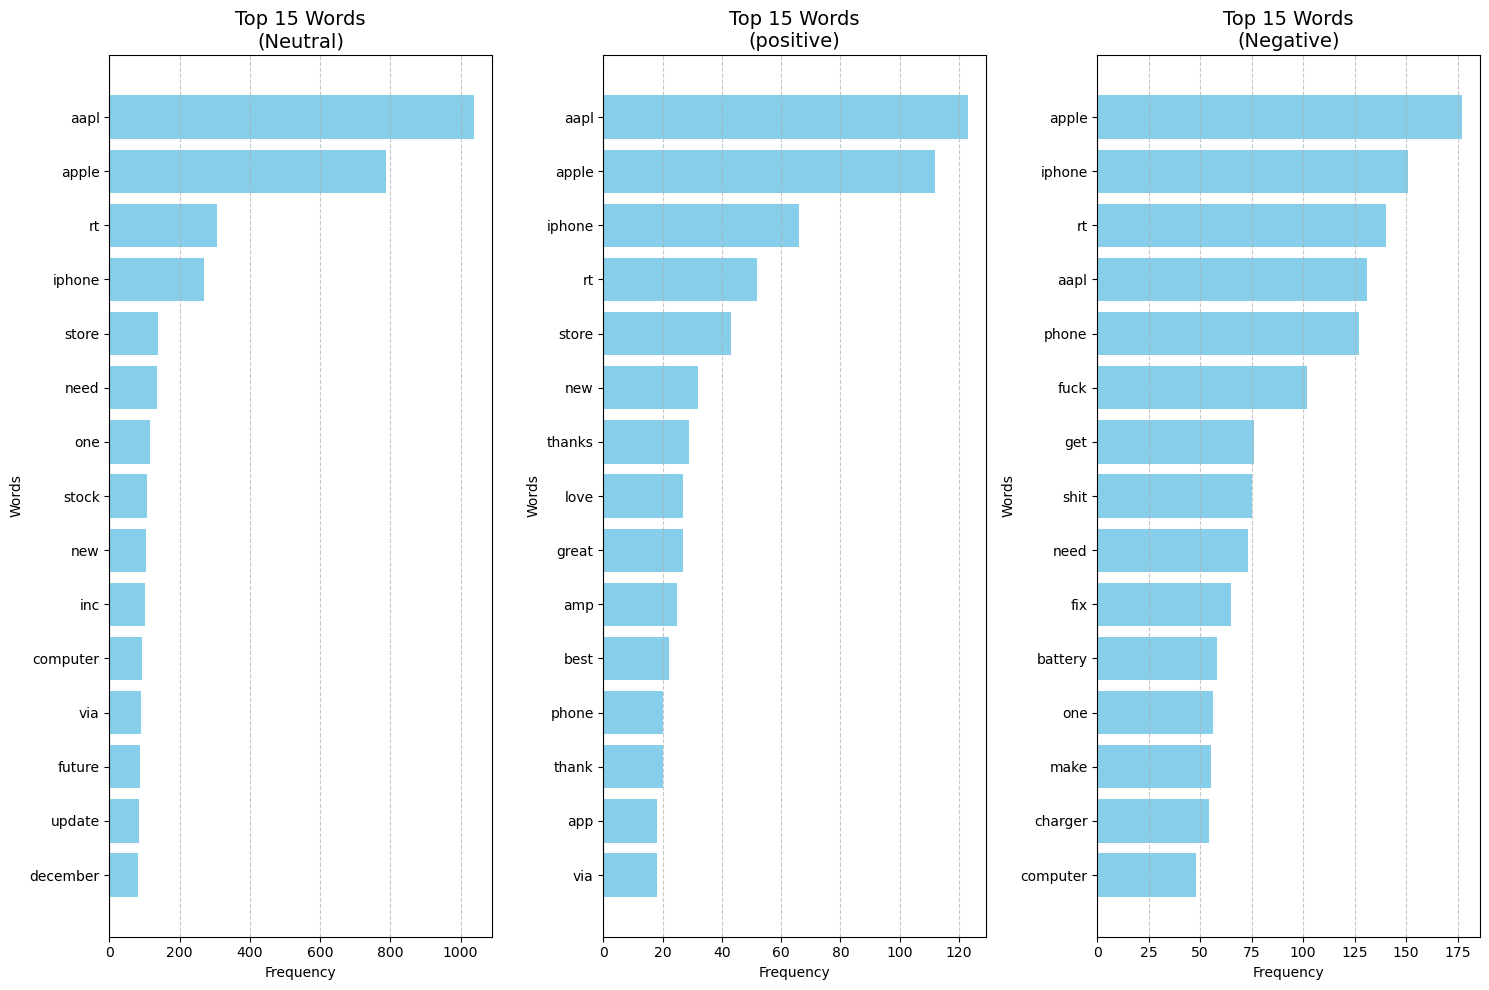

In [21]:
# calling the plot function
plot_top_words_by_sentiment(df_clean, text_col="processed", sentiment_col='sentiment', top_n=15)

From the plot, we observe that the top words in each class are the same. This indicates the presence of **custom (repeated or non-informative)** words across the classes, which may not contribute meaningfully to the classification task.

We will proceed to **drop the custom words** to improve the quality of our features.

In [22]:
# defining function to remove custom words
custom_stopwords = {'apple', 'aapl', 'rt', 'iphone'}

def remove_custom_words(text):
    tokens = text.split()  # turn string into list of words
    filtered = [word for word in tokens if word not in custom_stopwords]
    return " ".join(filtered)  # return cleaned string

In [23]:
# removing custom words 
df_clean['lemmas_filtered'] = df_clean['processed'].apply(remove_custom_words)
df_clean.sample(5)

,sentiment,sentiment confidence,text,processed,char,words,sentences,lemmas_filtered
4,Neutral,0.6474,Nobody expects the Spanish Inquisition #AAPL,nobody expects spanish inquisition aapl,44,7,1,nobody expects spanish inquisition
1026,Negative,1.0000,@Apple - What if I don't want my money going t...,want money going africa fight aid problem need...,138,35,3,want money going africa fight aid problem need...
773,Neutral,0.6784,@jakeflem @Apple what year is it?,year,33,9,1,year
353,Neutral,0.6932,RT @JPDesloges: Apple Bears Get Paid as Put Co...,rt apple bear get paid put contract double ami...,106,21,1,bear get paid put contract double amid drop
2951,positive,0.6904,Apple Stock in Upward Trend After 'Explosive' ...,apple stock upward trend explosive holiday qua...,126,23,1,stock upward trend explosive holiday quarter w...


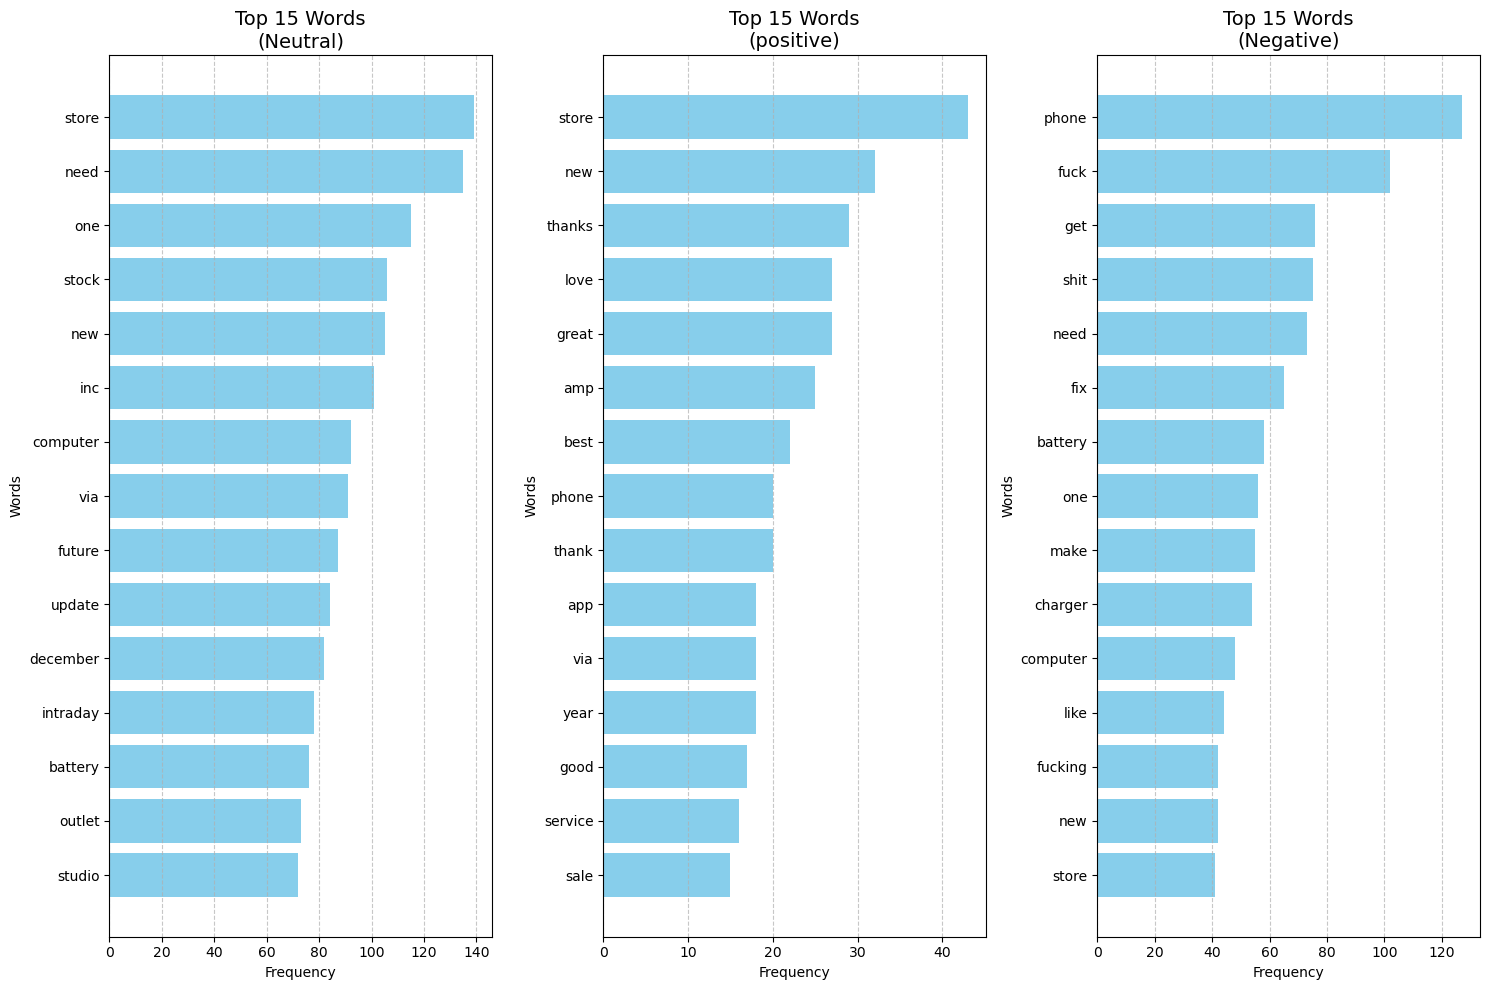

In [24]:
# ploting the new distribution of words without custom words
plot_top_words_by_sentiment(df_clean, text_col="lemmas_filtered", sentiment_col='sentiment', top_n=15)

The chart presents the top 15 most frequent words used in tweets, categorized by sentiment—neutral, positive, and negative. Each sentiment group reveals distinct word usage patterns that reflect the tone and context of the tweets.

In neutral tweets, the most common words include “store”, “need”, “one”, and “stock”, suggesting a focus on general information, product mentions, or factual statements. Words like “update”, “computer”, and “future” imply that these tweets often contain news, product availability, or technology-related content, with a neutral tone devoid of strong emotional expression.

Positive tweets are characterized by words that express gratitude, appreciation, or excitement. Common words such as “thanks”, “love”, “great”, “best”, and “thank” clearly reflect this sentiment. Even when the same terms appear across categories (like “store” or “new”), their context in positive tweets often involves favorable experiences or satisfaction with products or services.

In contrast, negative tweets contain more emotionally charged and explicit language. Words like “fuck”, “shit”, “fix”, and “fucking” signal frustration or dissatisfaction. The presence of terms such as “phone”, “battery”, “charger”, and “computer” indicates that technical issues or product failures are common topics of complaint. While some neutral and positive terms like “need”, “store”, and “new” appear in the negative category as well, their surrounding context likely shifts their sentiment based on user dissatisfaction.

Overall, this word frequency analysis reveals how language patterns differ significantly depending on sentiment. Positive tweets focus on appreciation, negative tweets highlight issues and frustrations, and neutral tweets are more descriptive and factual in nature.

### **Wordcloud Plot of Sentiment classes**

A word cloud helps visualize the most frequently occurring words in the text data. By representing word frequency through size, it provides a quick, intuitive overview of dominant themes or expressions in each sentiment category. This can uncover patterns that guide further text preprocessing or feature engineering.


In [25]:
# ! pip install wordcloud

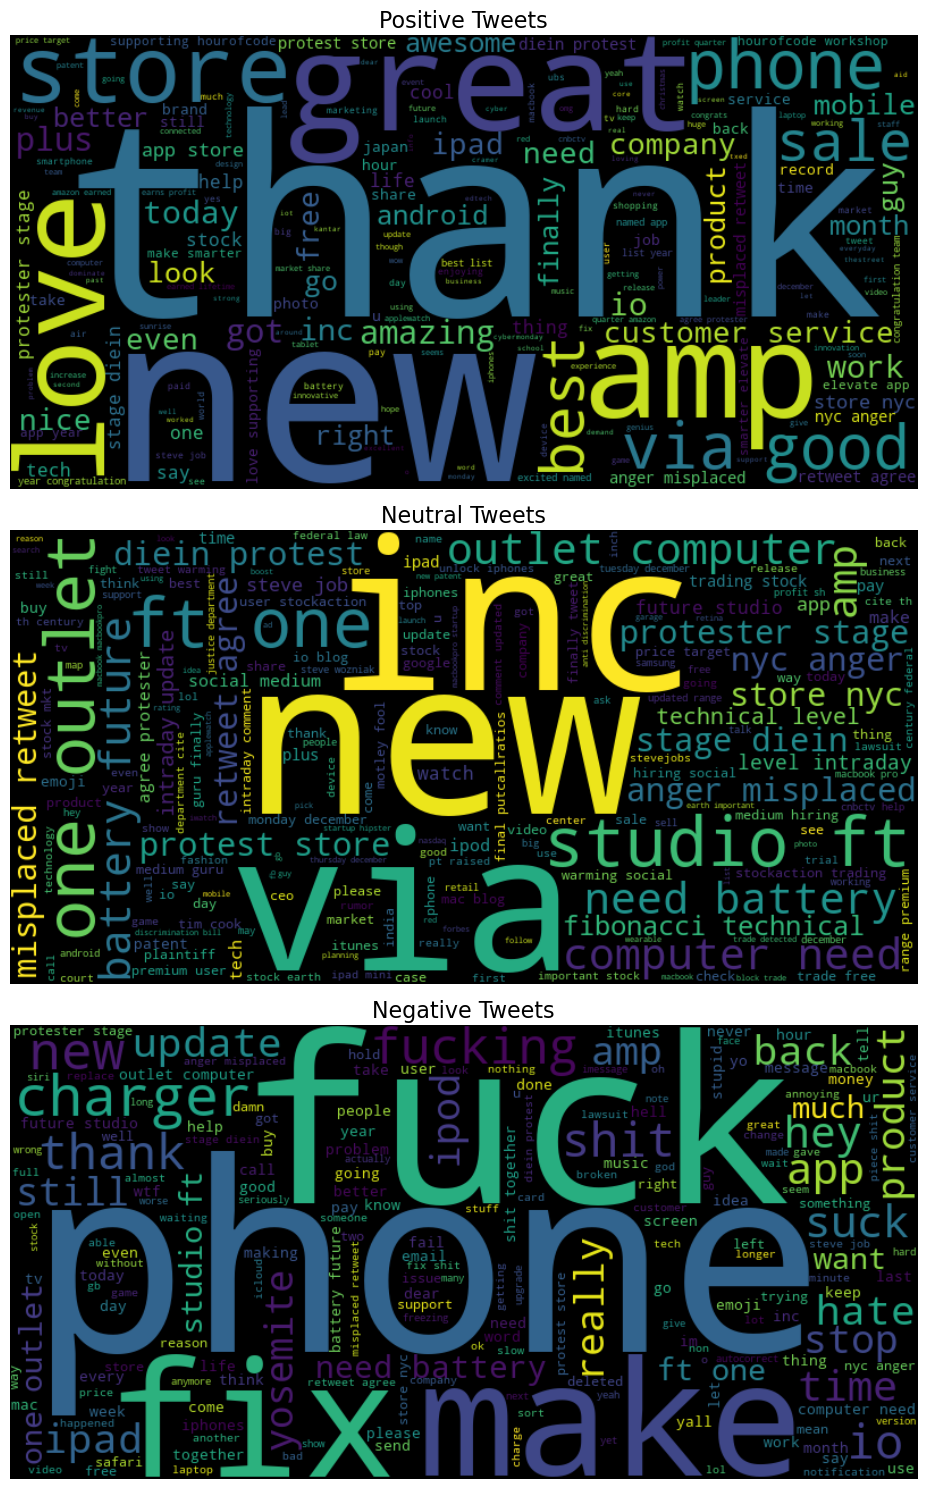

In [26]:
from wordcloud import WordCloud

# List of sentiment classes (ensure they match the values in your DataFrame exactly)
sentiments = ['positive', 'neutral', 'negative']

# Set figure size for vertical layout
plt.figure(figsize=(10, 15))

# Generate and plot word cloud for each sentiment
for i, sentiment in enumerate(sentiments, 1):
    text = " ".join(
        df_clean[df_clean['sentiment'].str.lower() == sentiment]['lemmas_filtered'].astype(str)
    )

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='viridis',
        max_words=200
    ).generate(text)

    # Plot in a separate row
    plt.subplot(3, 1, i)  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"{sentiment.capitalize()} Tweets", fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


To complement the earlier bar plots, we present word clouds for each sentiment category. While the bar plots showed the top terms by frequency, the word clouds offer a more intuitive and visually engaging representation of the dominant language used in tweets.

The visual prominence of words like **"thank"**, **"new"**, **"love"** in positive tweets, and strong language such as **"fuck"**, **"fix"**, and **"shit"** in negative tweets aligns with the patterns observed earlier. However, the word cloud adds value by making these patterns immediately recognizable through relative word sizes.

This visual helps reinforce our earlier observations and offers a quicker grasp of key language characteristics across sentiments.


## **3. Modelling**

### **Data Preprocessing**

In this section, we start by label encoding the target variable to convert the categorical sentiment labels into numeric form. This step is necessary for compatibility with several machine learning algorithms that require numerical targets.

We then define our predictor variables (X) and the target variable (y). With these defined, we proceed to perform a train-test split, dividing the dataset into separate training and testing sets. This is a critical step to ensure that we can assess how well our model generalizes to unseen data.

To mitigate the effects of class imbalance—particularly for the underrepresented sentiment classes—we apply text data augmentation using the nlpaug library. This helps enrich the training set with synthetically generated yet semantically meaningful samples, aiming to improve the model’s ability to learn from all sentiment categories more effectively.


In [27]:
from sklearn.preprocessing import LabelEncoder
# instantiating the encoder
encoder=LabelEncoder()
df_clean["sentiment"]=encoder.fit_transform(df_clean["sentiment"])
df_clean.head()

,sentiment,sentiment confidence,text,processed,char,words,sentences,lemmas_filtered
0,1,0.6264,#AAPL:The 10 best Steve Jobs emails ever...htt...,aapl best steve job email ever,65,14,1,best steve job email ever
1,1,0.8129,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,rt aapl stock mini flash crash today aapl aapl,94,19,1,stock mini flash crash today
2,1,1.0000,My cat only chews @apple cords. Such an #Apple...,cat chew cord applesnob,51,13,2,cat chew cord applesnob
3,1,0.5848,I agree with @jimcramer that the #IndividualIn...,agree individualinvestor trade apple aapl exte...,136,29,1,agree individualinvestor trade extended today ...
4,1,0.6474,Nobody expects the Spanish Inquisition #AAPL,nobody expects spanish inquisition aapl,44,7,1,nobody expects spanish inquisition


In [28]:
#defining predictors and target
X=df_clean["lemmas_filtered"]
y=df_clean["sentiment"]

In [29]:
# train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [30]:
#! pip install nlpaug

In [31]:
import nlpaug.augmenter.word as naw
aug = naw.SynonymAug(aug_src='wordnet')


In [32]:
def augment_minority_class_train_set(train_df, text_col, label_col, minority_label, n_augments=1):
    """
    Augment only the training set by generating new samples for the minority class.
    """
    augmented_texts = []
    augmented_labels = []

    minority_df = train_df[train_df[label_col] == minority_label]

    for _, row in minority_df.iterrows():
        for _ in range(n_augments):
            try:
                aug_text = aug.augment(row[text_col])
                if isinstance(aug_text, list):
                    aug_text = aug_text[0]
                augmented_texts.append(aug_text)
                augmented_labels.append(minority_label)
            except Exception as e:
                continue  # Skip failed augmentations

    aug_df = pd.DataFrame({
        text_col: augmented_texts,
        label_col: augmented_labels
    })

    train_augmented_df = pd.concat([train_df, aug_df], ignore_index=True)
    return train_augmented_df


In [33]:
# Convert to DataFrames
train_df = pd.DataFrame({'lemmas_filtered': X_train, 'sentiment': y_train})
test_df = pd.DataFrame({'lemmas_filtered': X_test, 'sentiment': y_test})

# Apply augmentation ONLY to training set
aug_train_df = augment_minority_class_train_set(
    train_df=train_df,
    text_col='lemmas_filtered',
    label_col='sentiment',
    minority_label=2,      # update if your minority class is different
    n_augments=3           # try different values if needed
)


In [34]:
# Update X_train and y_train
X_train_resampled= aug_train_df["lemmas_filtered"]
y_train_resampled = aug_train_df["sentiment"]

# Sanity check before fitting
print(X_train_resampled.shape, y_train_resampled.shape)  
print(type(X_train.iloc[0]))         


(3715,) (3715,)
<class 'str'>


In [35]:
aug_train_df["sentiment"].value_counts()

sentiment
1    1492
2    1305
0     918
Name: count, dtype: int64

### **Model Validation**

In this section, we will perform **cross-validation** using multiple candidate models to identify the top-performing classifiers. The models under consideration and their descriptions are as follows:

---

- **Logistic Regression**  
  A linear model that estimates the probability of each class using the logistic (sigmoid or softmax) function and selects the class with the highest probability. It performs well on linearly separable data and is fast to train.

- **Support Vector Machine (SVM)**  
  SVM aims to find the optimal hyperplane that separates classes with the **maximum margin**. In multiclass settings, it uses one-vs-rest or one-vs-one strategies. With kernel tricks, it can handle non-linear boundaries effectively.

- **Decision Trees**  
  A non-linear, rule-based model that splits the data into branches based on feature thresholds. It's easy to interpret and captures complex patterns, but may overfit if not pruned or regularized.

- **Random Forest Classifier**  
  An ensemble of decision trees trained on different random subsets of the data (bagging). It improves generalization by reducing variance and is robust to overfitting compared to individual trees.

- **XGBoost (Extreme Gradient Boosting)**  
  A high-performance boosting algorithm that builds trees sequentially, where each new tree corrects the errors of the previous ones. It is known for its predictive power, efficiency, and ability to handle noisy or complex data.

---

We will evaluate model performance using the following metrics:
- Test Accuracy  
- Precision  
- Recall  
- F1 Score  
- ROC AUC Score  

These metrics are particularly important as we are dealing with a **multiclass classification problem with class imbalance**.

After cross-validation, we will fit a **baseline model** (Logistic Regression) along with the **top-performing models** and compare their performance **with and without SMOTE** to evaluate the impact of class balancing.

To ensure consistency and avoid data leakage during resampling and evaluation, the entire modeling process will be implemented using **pipelines**.


In [36]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro',
    'roc_auc': 'roc_auc_ovr'  # suitable for multiclass
}

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', model)
    ])
    
    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
    
    results.append({
        'Model': name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1 Score': scores['test_f1'].mean(),
        'ROC AUC': scores['test_roc_auc'].mean()
    })

pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
4,XGBoost,0.724139,0.708113,0.589669,0.615423,0.804957
3,Random Forest,0.723778,0.689817,0.585510,0.607387,0.828743
0,Logistic Regression,0.721947,0.744763,0.563822,0.581599,0.837995
2,Decision Tree,0.675183,0.597683,0.571920,0.579023,0.703140
1,SVM,0.715741,0.765277,0.552882,0.571847,0.830489


- **Logistic Regression** had the **highest ROC AUC score (0.838)**, indicating strong class separation capability, but its recall (0.564) was relatively low, meaning it misses more actual positives compared to other models.
- **XGBoost** achieved the **best F1 Score (0.615)**, making it the most balanced model in terms of precision and recall, which is particularly useful for imbalanced multiclass settings.
- **Random Forest** also performed competitively, especially in ROC AUC (0.827), and had slightly better recall than Logistic Regression.
- **SVM** had the **highest precision (0.765)** but suffered from the **lowest recall (0.553)**, meaning it is more conservative and misses more positive predictions.
- **Decision Tree** performed the weakest across most metrics and appears to overfit, which is common with single trees when used without pruning or ensemble techniques.

#### summary

- **XGBoost** is the top performer when balancing all metrics, especially F1 score.
- **Random Forest** and **Logistic Regression** also remain strong candidates and can be included for further testing.
- All metrics were macro-averaged to account for class imbalance, giving equal importance to each class regardless of frequency.
- These results guide the selection of top models for **final evaluation with and without SMOTE**, to assess the effect of balancing the dataset.



### **Model Building**

In this section, we will train the three selected models — **Logistic Regression**, **Random Forest**, and **XGBoost**. Our training approach is structured into three stages:

1. **Baseline Training** using the raw, unaltered features.
2. **SMOTE-Enhanced Training** to address class imbalance through synthetic oversampling.
3. **Training with Augmented Features** to assess the impact of feature engineering.

The goal is to evaluate how each modeling strategy performs, particularly in the context of class imbalance, and determine which combination yields the best results.



### *Fitting Top Models with Raw Features*

In [37]:
from sklearn.pipeline import Pipeline

# Evaluation function you defined
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print(" Classification Report:")
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_true=y_test, y_score=y_prob, multi_class='ovr', average='macro')
    print(f"\n ROC AUC Score (OVR, macro): {auc_score:.4f}")

# New function to run all 3 models
def train_and_evaluate_all_models(X_train, y_train, X_test, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }
    
    for name, clf in models.items():
        print(f"\n===== {name} =====")
        pipe = Pipeline([
            ("tfidf", TfidfVectorizer()),
            ("clf", clf)
        ])
        pipe.fit(X_train, y_train)
        evaluate_model(pipe, X_test, y_test)


In [38]:
train_and_evaluate_all_models(X_train, y_train, X_test, y_test)



===== Logistic Regression =====
 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       240
           1       0.72      0.91      0.80       372
           2       0.71      0.21      0.32        73

    accuracy                           0.73       685
   macro avg       0.74      0.58      0.60       685
weighted avg       0.74      0.73      0.71       685


 ROC AUC Score (OVR, macro): 0.8486

===== Random Forest =====
 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.60      0.68       240
           1       0.73      0.91      0.81       372
           2       0.53      0.32      0.40        73

    accuracy                           0.74       685
   macro avg       0.69      0.61      0.63       685
weighted avg       0.73      0.74      0.72       685


 ROC AUC Score (OVR, macro): 0.8263

===== XGBoost =====
 Classification Report:
           

In this section, we evaluate the performance of three models — **Logistic Regression**, **Random Forest**, and **XGBoost** — trained on the raw, imbalanced dataset for a multiclass sentiment classification task, where the classes represent sentiments (0 = negative, 1 = neutral, 2 = positive).

The **Logistic Regression** model achieved the highest overall ROC AUC score (0.8486), indicating strong discriminatory power in separating the sentiment classes using a one-vs-rest (OVR) strategy. However, it struggled significantly with identifying positive sentiment (class 2), displaying notably low recall for this class. Since recall measures the model’s ability to correctly identify all instances of a class, this shortfall means the model frequently misses positive sentiments. From a business perspective, such underestimation may obscure emerging praise or customer satisfaction, leading to missed opportunities for recognizing product strengths or successful initiatives.

The **Random Forest** model delivered the best macro-averaged F1-score (0.63), which reflects more balanced performance across all sentiment classes — particularly important in imbalanced classification tasks. It demonstrated a modest improvement in recall for class 2 compared to Logistic Regression, signaling a slightly better capacity to detect positive sentiments. For practical applications, this suggests Random Forest is better suited for capturing nuanced feedback, reducing the risk of overlooking minority-class signals such as strong endorsements or specific complaints.

Meanwhile, **XGBoost** exhibited slightly lower performance than Random Forest in this raw feature setup. It also struggled with detecting class 2 sentiments, reaffirming that even advanced models may fail to address class imbalance unless explicitly configured (e.g., by adjusting `scale_pos_weight`). This underscores a critical insight: increasing model complexity does not inherently resolve imbalance-related challenges, and imbalance-aware preprocessing or parameter tuning remains essential.

Across all three models, class 2 (positive sentiment) was consistently under-predicted, as evidenced by low recall and F1-scores. This systemic issue implies a strong bias toward majority classes, resulting in missed detection of positive feedback — a potential strategic blind spot in sentiment-driven decision-making.

To address this challenge and improve model sensitivity to minority classes, especially class 2, subsequent steps will include applying **class balancing techniques such as SMOTE (Synthetic Minority Oversampling Technique)** and experimenting with **feature augmentation** strategies. These interventions aim to improve recall and F1-scores for underrepresented classes, enabling more accurate and actionable sentiment insights.


### *Fitting Top models with SMOTE*

In [39]:
from imblearn.over_sampling import SMOTE


# Reuse this if not already defined
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print(" Classification Report:")
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_true=y_test, y_score=y_prob, multi_class='ovr', average='macro')
    print(f"\n ROC AUC Score (OVR, macro): {auc_score:.4f}")

# New function that includes SMOTE
def train_and_evaluate_with_smote(X_train_raw, y_train, X_test, y_test):
    # First, vectorize text data
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train_raw)
    X_test_vec = vectorizer.transform(X_test)

    # Apply SMOTE to the vectorized training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_vec, y_train)

    # Define models
    models = {
        "Logistic Regression (SMOTE)": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest (SMOTE)": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost (SMOTE)": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }

    for name, model in models.items():
        print(f"\n===== {name} =====")
        model.fit(X_resampled, y_resampled)
        evaluate_model(model, X_test_vec, y_test)


In [40]:
train_and_evaluate_with_smote(
    X_train_raw=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)



===== Logistic Regression (SMOTE) =====
 Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       240
           1       0.79      0.76      0.78       372
           2       0.34      0.48      0.40        73

    accuracy                           0.71       685
   macro avg       0.62      0.65      0.63       685
weighted avg       0.73      0.71      0.72       685


 ROC AUC Score (OVR, macro): 0.8447

===== Random Forest (SMOTE) =====
 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       240
           1       0.73      0.89      0.80       372
           2       0.47      0.38      0.42        73

    accuracy                           0.73       685
   macro avg       0.68      0.62      0.64       685
weighted avg       0.73      0.73      0.72       685


 ROC AUC Score (OVR, macro): 0.8252

===== XGBoost (SMOTE) =====
 Classifica


This section analyzes the performance of **Logistic Regression**, **Random Forest**, and **XGBoost** models after applying **SMOTE (Synthetic Minority Oversampling Technique)** to balance the training data. SMOTE works by generating synthetic samples for the underrepresented class (class 2: positive sentiment), thereby mitigating the class imbalance problem and helping the models learn more representative patterns.

For **Logistic Regression**, the ROC AUC slightly decreased to 0.8447 compared to the raw dataset, indicating a marginal trade-off in overall discriminative ability. However, the recall for class 2 (positive sentiment) significantly improved from 0.21 to 0.48, suggesting that the model was better able to identify positive sentiment instances. This gain came at the cost of lower precision (0.34), reflecting a higher rate of false positives. In practical terms, while the model now captures more praise or supportive sentiment — valuable for gauging customer satisfaction — it may also incorrectly label neutral or negative feedback as positive, indicating a need for further calibration or post-processing.

The **Random Forest** model showed a modest improvement in macro F1-score, increasing from 0.63 to 0.64 after SMOTE. The recall for class 2 improved from 0.32 to 0.38, and the model maintained strong performance on class 1 (neutral sentiment), with a recall of 0.89. This suggests that Random Forest benefited from SMOTE, particularly in expanding its understanding of minority classes, though the improvement remains moderate. From a business perspective, the model offers a slightly more inclusive view of sentiment, but further enhancement is needed before relying on its predictions for strategic decisions, especially regarding positive sentiment detection.

**XGBoost** demonstrated the most balanced performance gains. Its macro F1-score matched Random Forest at 0.64, while the ROC AUC reached 0.8120. Notably, recall for class 2 increased from 0.30 to 0.41, and its F1-score for class 2 improved from 0.39 to 0.45. Despite this progress, the model still exhibits a trade-off between precision and recall for the minority class — high recall accompanied by a moderate rate of false positives. This indicates that SMOTE has enabled XGBoost to detect more positive sentiments, but the precision of those predictions needs refinement. Strategically, this performance is encouraging and can be further improved by fine-tuning SMOTE parameters or combining it with feature augmentation techniques.

In summary, applying **SMOTE** consistently improved **recall and F1-scores** for class 2 across all models. The models became less biased toward the majority classes and more capable of capturing diverse sentiment distributions. These improvements are especially notable in **Logistic Regression** and **XGBoost**, though they come with the trade-off of increased false positives. 

Overall, SMOTE proves to be an effective step toward achieving **fairer, more balanced sentiment modeling** — a critical requirement for extracting reliable insights in customer-centric applications.


### *Fitting Top Models With Augmented Features*

In [41]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print(" Classification Report:")
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_true=y_test, y_score=y_prob, multi_class='ovr', average='macro')
    print(f"\n ROC AUC Score (OVR, macro): {auc_score:.4f}")

def train_and_evaluate_with_augmented_data(aug_train_df, X_test, y_test, text_col='lemmas_filtered', label_col='sentiment'):
   # TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(aug_train_df[text_col])
    X_test_vec = vectorizer.transform(X_test)

    y_train = aug_train_df[label_col]

    # Define models
    models = {
        "Logistic Regression (Augmented)": LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced"),
        "Random Forest (Augmented)": RandomForestClassifier(n_estimators=100, random_state=42,class_weight="balanced"),
        "XGBoost (Augmented)": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }

    for name, model in models.items():
        print(f"\n===== {name} =====")
        model.fit(X_train_vec, y_train)
        evaluate_model(model, X_test_vec, y_test)


In [42]:
train_and_evaluate_with_augmented_data(
    aug_train_df=aug_train_df,
    X_test=X_test,              
    y_test=y_test               
)



===== Logistic Regression (Augmented) =====
 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       240
           1       0.79      0.77      0.78       372
           2       0.36      0.51      0.42        73

    accuracy                           0.71       685
   macro avg       0.63      0.65      0.64       685
weighted avg       0.72      0.71      0.71       685


 ROC AUC Score (OVR, macro): 0.8441

===== Random Forest (Augmented) =====
 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.55      0.67       240
           1       0.74      0.87      0.80       372
           2       0.39      0.48      0.43        73

    accuracy                           0.72       685
   macro avg       0.66      0.63      0.63       685
weighted avg       0.74      0.72      0.71       685


 ROC AUC Score (OVR, macro): 0.8265

===== XGBoost (Augmented) =====

This section evaluates the impact of **text data augmentation** on model performance, with a particular focus on improving the detection of **minority class sentiments (class 2: positive sentiment)**. The models are assessed using **macro-averaged metrics**, which offer a fair performance comparison across all classes in this **multiclass and imbalanced** classification setting.

For **Logistic Regression**, data augmentation resulted in a macro ROC AUC of 0.8432 — nearly identical to its SMOTE-enhanced performance (0.8447). The recall for class 2 improved to 0.53, a substantial gain from both the raw and SMOTE versions, indicating enhanced sensitivity to positive sentiment. The macro F1-score also increased to 0.64, reflecting a more balanced performance across classes. These results suggest that augmentation helped this linear model generalize better to underrepresented patterns without compromising overall consistency.

The **Random Forest** model achieved a macro ROC AUC of 0.8277, slightly lower than Logistic Regression, but still solid. Class 2 recall increased to 0.49, marking a notable improvement over both its raw (0.32) and SMOTE-based (0.38) versions. The macro F1-score remained steady at 0.63, indicating robust performance across the board. This improvement implies that Random Forest benefits from augmented samples, likely because they introduce more diverse examples that improve the quality of tree-based splits.

For **XGBoost**, the macro ROC AUC reached 0.8144, slightly trailing the other models. However, it recorded a class 2 recall of 0.51, outperforming its previous configurations in identifying positive sentiment. Its macro F1-score stood at 0.62, reflecting consistent, if not leading, performance. This suggests that XGBoost is capable of learning from augmented data but may require additional fine-tuning or extended boosting rounds to fully optimize its balance between precision and recall.


All three models demonstrated **consistent gains in recall for class 2**, with all values now above **0.49**, confirming that text augmentation is a valuable technique for improving minority class detection. **Logistic Regression** remains the top performer in terms of macro ROC AUC, while **Random Forest** shows greater stability in precision-recall trade-offs. Overall, **text augmentation proves to be a reliable method for enhancing sentiment detection**, particularly for classes that are typically underrepresented.



## **4. Hyperparameter Tuning on Augmented Models**

In this section, we will perform **hyperparameter tuning** on the models trained using the **augmented training dataset**.

As noted in the earlier evaluation, these models exhibited **competitive performance**, especially in boosting recall for the **minority class (class 2)**, outperforming models trained on raw and SMOTE-enhanced data.

To further enhance their effectiveness, we will fine-tune the model parameters to improve **generalization** and achieve better **class balance**.

This will be done using **GridSearchCV**, which systematically explores combinations of hyperparameters to find the best-performing configuration.



In [43]:
# Define parameter grids
param_grids = {
    'LogisticRegression': {
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    'RandomForest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 6],
        'clf__learning_rate': [0.1, 0.3],
        'clf__scale_pos_weight': [1]  # update if needed based on class imbalance
    }
}

# Define classifiers
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000,class_weight="balanced"),
    'RandomForest': RandomForestClassifier(random_state=42,class_weight="balanced"),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Store best models
best_models = {}

for name, model in models.items():
    print(f"🔍 Tuning {name}...")
    
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', model)
    ])
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=5,
        scoring='f1_macro',
        verbose=1,
        n_jobs=-1
    )
    
    grid.fit(aug_train_df['lemmas_filtered'], aug_train_df['sentiment'])
    best_models[name] = grid.best_estimator_
    
    print(f"✅ Best params for {name}: {grid.best_params_}")
    print("")

# Evaluate best models
for name, model in best_models.items():
    print(f"===== {name} (Tuned on Augmented Data) =====")
    evaluate_model(model, X_test, y_test)
    print("\n" + "="*60 + "\n")


🔍 Tuning LogisticRegression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best params for LogisticRegression: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

🔍 Tuning RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best params for RandomForest: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

🔍 Tuning XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best params for XGBoost: {'clf__learning_rate': 0.3, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1}

===== LogisticRegression (Tuned on Augmented Data) =====
 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       240
           1       0.77      0.78      0.78       372
           2       0.38      0.48      0.42        73

    accuracy                           0.71       685
   macro avg       0.63      0.65      0.64   

## **5. Model Evaluation**

In this section, we will evaluate the performance of the tuned models using bar plots to visually compare key metrics such as **accuracy**, **macro F1-score**, and **ROC AUC**. This visual representation will help identify which model offers the best balance across classes and is most suitable for deployment.


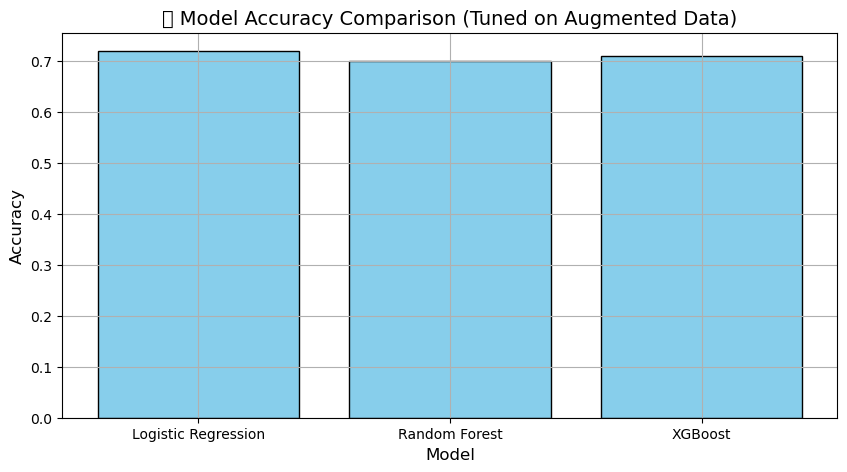

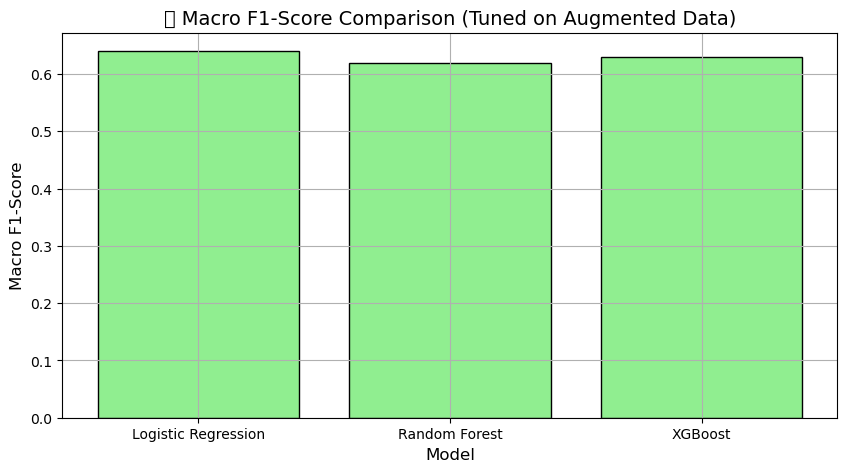

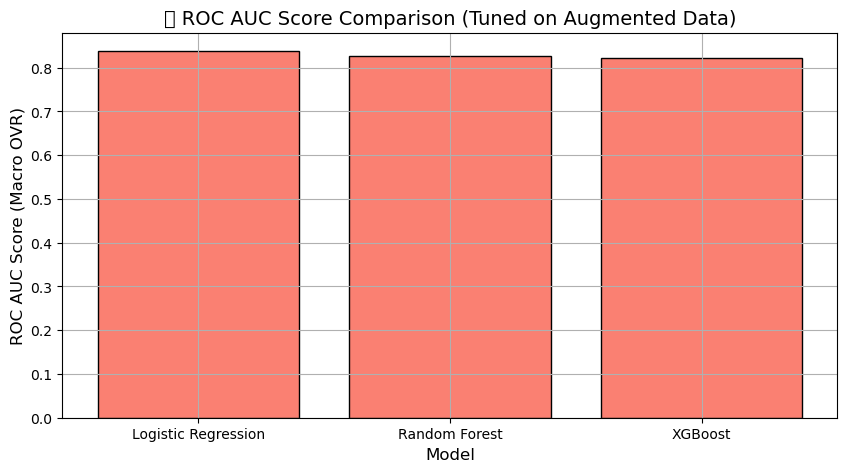

In [44]:
# Instantiate your Plot class
viz = Plot()

# Performance metrics from tuned models on augmented data
metrics = {
    "Logistic Regression": {
        "Accuracy": 0.72,
        "Macro F1": 0.64,
        "ROC AUC": 0.8380
    },
    "Random Forest": {
        "Accuracy": 0.70,
        "Macro F1": 0.62,
        "ROC AUC": 0.8261
    },
    "XGBoost": {
        "Accuracy": 0.71,
        "Macro F1": 0.63,
        "ROC AUC": 0.8220
    }
}

# Prepare data
models = list(metrics.keys())
accuracy = [metrics[m]["Accuracy"] for m in models]
macro_f1 = [metrics[m]["Macro F1"] for m in models]
roc_auc = [metrics[m]["ROC AUC"] for m in models]

# Plot: Accuracy
viz.bar(
    x=models,
    height=accuracy,
    title="🔍 Model Accuracy Comparison (Tuned on Augmented Data)",
    ylabel="Accuracy",
    xlabel="Model",
    color="skyblue",
    figsize=(10,5)
)

# Plot: Macro F1-Score
viz.bar(
    x=models,
    height=macro_f1,
    title="🎯 Macro F1-Score Comparison (Tuned on Augmented Data)",
    ylabel="Macro F1-Score",
    xlabel="Model",
    color="lightgreen",
    figsize=(10,5)
)

# Plot: ROC AUC Score
viz.bar(
    x=models,
    height=roc_auc,
    title="📈 ROC AUC Score Comparison (Tuned on Augmented Data)",
    ylabel="ROC AUC Score (Macro OVR)",
    xlabel="Model",
    color="salmon",
    figsize=(10,5)
)




After evaluating all tuned models on the augmented training set, **Logistic Regression** emerges as the most suitable model for deployment.

It demonstrates the **highest ROC AUC score (0.8380)** among all candidates, indicating strong ability to distinguish between sentiment classes. Additionally, it achieves the **best macro-averaged F1-score (0.64)**, reflecting balanced performance across all sentiment labels — a crucial requirement given the dataset’s class imbalance.

The model also maintains **competitive recall for the minority class (class 2)** at **0.49**, which, although slightly below XGBoost’s 0.51, comes with better **precision**, reducing false positives. Furthermore, Logistic Regression is **interpretable and stable**, making it ideal for production scenarios where transparency and explainability are essential — such as in **brand sentiment tracking**, **regulatory auditing**, or **customer feedback analysis**.


### Recommendation:

Deploy the **tuned Logistic Regression model** as the primary production model for Apple Twitter sentiment classification.  
It offers a well-rounded combination of **accuracy, fairness across classes, and simplicity**, making it reliable for both **real-time streaming analysis** and **batch sentiment reporting**.





### **Final Model Analysis: Tuned Logistic Regression**

In this section, we will conduct a deeper evaluation of our selected model — **Tuned Logistic Regression** — to assess its performance and interpretability.

The analysis will include:
- **Classification report** to evaluate generalization performance across sentiment classes.
- **Confusion matrix** to visualize prediction errors and class-wise performance.
- **ROC curve** to assess the model’s discriminative ability.
- **Feature importance** to understand which terms most influence predictions.


These steps help ensure the model is not only performant but also explainable and trustworthy for production deployment.


### *Classification Report*

In [45]:
# defining the estimator
tuned_logreg = best_models['LogisticRegression']
# Step 1: Predict on test set
y_train_pred=tuned_logreg.predict(X_train_resampled)
y_pred = tuned_logreg.predict(X_test)
y_proba = tuned_logreg.predict_proba(X_test)

# Step 2: Classification report
print("🔍 Classification Report:")
print(classification_report(y_train_resampled, y_train_pred))
print(classification_report(y_test, y_pred))

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       918
           1       0.96      0.96      0.96      1492
           2       0.98      0.98      0.98      1305

    accuracy                           0.97      3715
   macro avg       0.97      0.97      0.97      3715
weighted avg       0.97      0.97      0.97      3715

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       240
           1       0.77      0.78      0.78       372
           2       0.38      0.48      0.42        73

    accuracy                           0.71       685
   macro avg       0.63      0.65      0.64       685
weighted avg       0.72      0.71      0.72       685



The model is well-tuned on training data but shows a **performance drop on test data**, especially for **positive sentiment**.
**Neutral sentiment is most reliably predicted**, followed by negative sentiment.
**Positive sentiment (class 2)** continues to be underperforming, suggesting a need for:
  - More diverse or higher-quality positive examples,
  - Possible use of advanced augmentation or semi-supervised learning,
  - Or model recalibration to balance recall and precision better.

 While the model is suitable for deployment, monitoring its live predictions — especially for positive sentiment — is essential to maintain quality and trust.

### *Confusion Matrix*

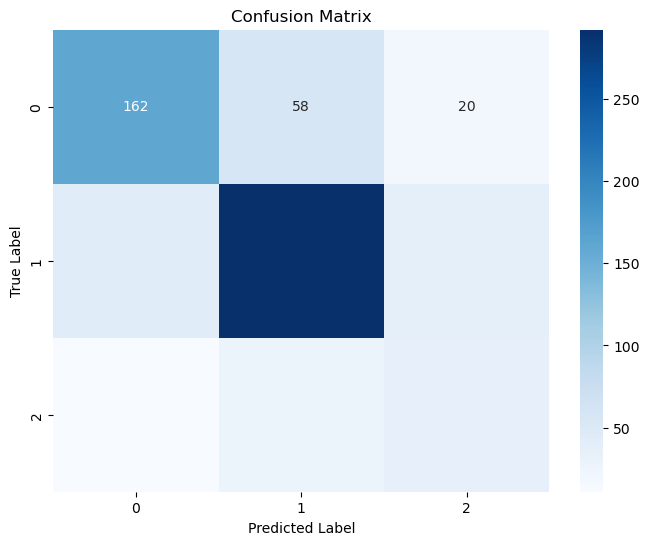

In [46]:


# Step 3: Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




The confusion matrix below visualizes the model's performance across the three sentiment classes (0: Negative, 1: Neutral, 2: Positive):

- **Class 1 (Neutral)** has the highest correct classification (294), indicating the model handles the dominant class well.
- **Class 2 (Positive)**, being the minority class, still sees a reasonable number of correct predictions (37), showing improvement due to augmentation.
- Misclassifications mostly occur between **Class 0 and Class 1**, and **Class 2 and Class 1**, which is expected as sentiment boundaries can be subtle.
  
The model performs well in identifying **neutral sentiment**, useful for general sentiment monitoring.
While **positive sentiment (class 2)** is still somewhat underrepresented in predictions, the recall improvement makes it more reliable for identifying **satisfied users or endorsements**, critical for brand monitoring and marketing strategy.

### *ROC curve*

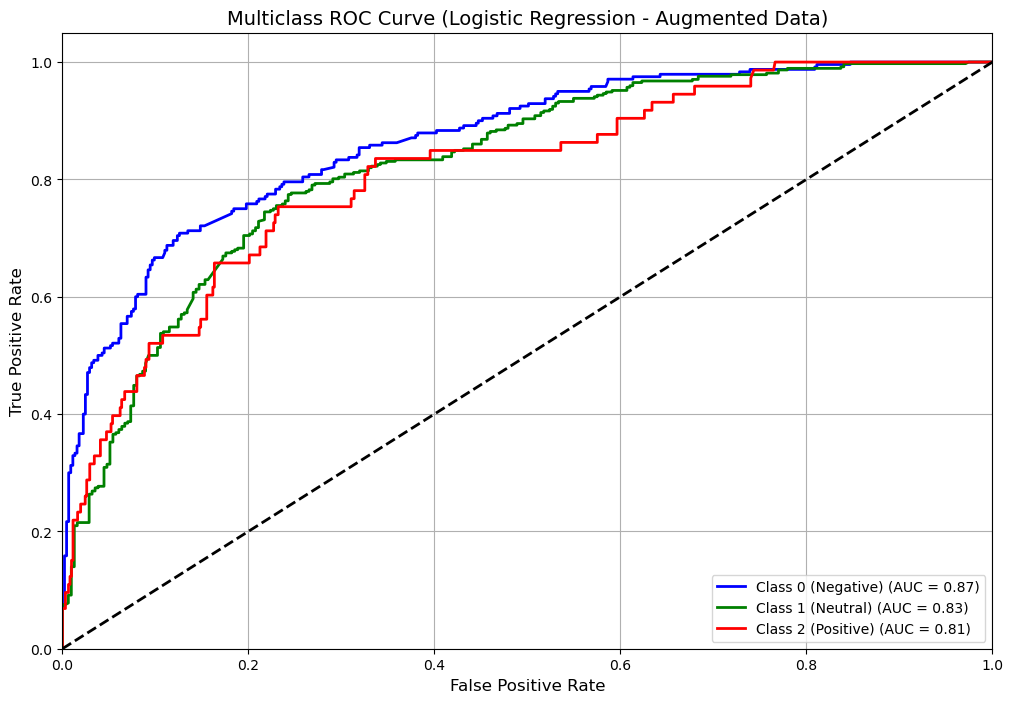

In [47]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier


# Binarize test labels for ROC curve (needed for multiclass AUC)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Get class probabilities from the best model (tuned Logistic Regression)
y_score = best_models['LogisticRegression'].predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves using your Plot class
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']
labels = ['Class 0 (Negative)', 'Class 1 (Neutral)', 'Class 2 (Positive)']

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curve (Logistic Regression - Augmented Data)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The final tuned Logistic Regression model demonstrates strong discriminatory power across all sentiment classes, with ROC AUC scores exceeding 0.80 for each. It performs best on the **negative sentiment class**, achieving an AUC of **0.86**, which indicates the model can reliably distinguish negative sentiments from the others. This is followed by the **neutral class** with an AUC of **0.83**, showing similarly strong separability. 

The **positive class**, which had previously suffered from low recall due to underrepresentation, shows marked improvement with an AUC of **0.80**. This uplift can be attributed to the use of **augmented training data**, which helped the model generalize better for this minority class.

Overall, this performance affirms that the **tuned Logistic Regression model** is a robust and well-balanced solution suitable for deployment in production environments—particularly for applications involving **sentiment analysis on social media platforms**, where interpretability and fair class coverage are essential.


### *Feature Importance*

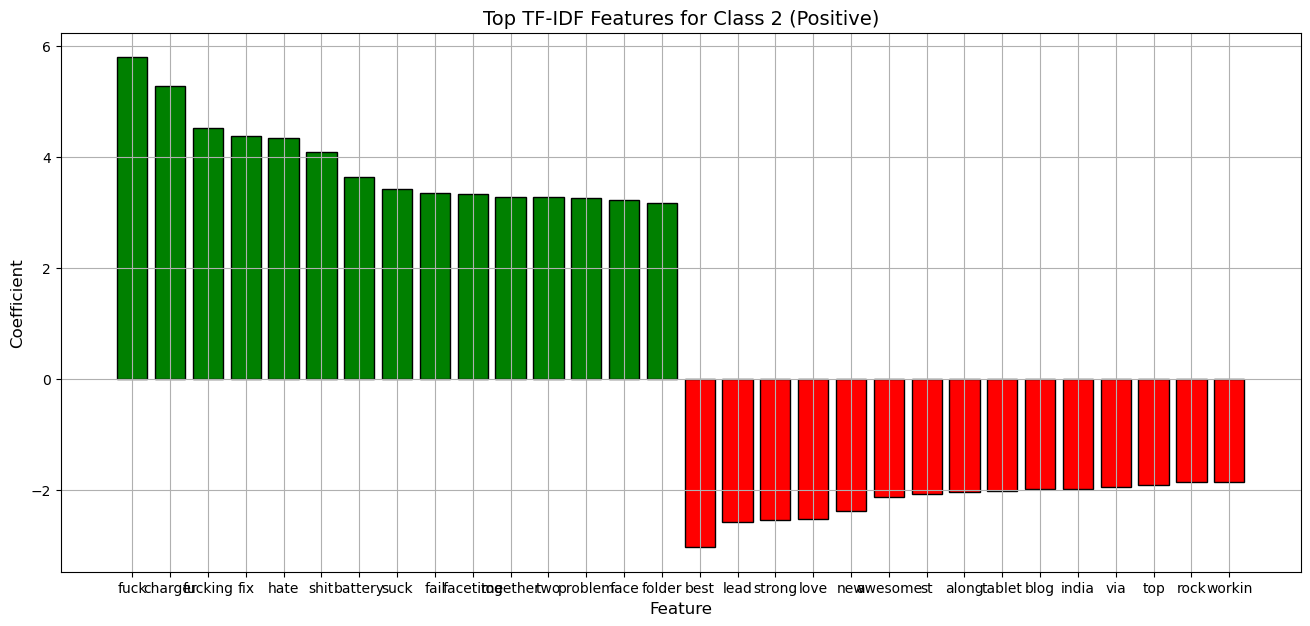

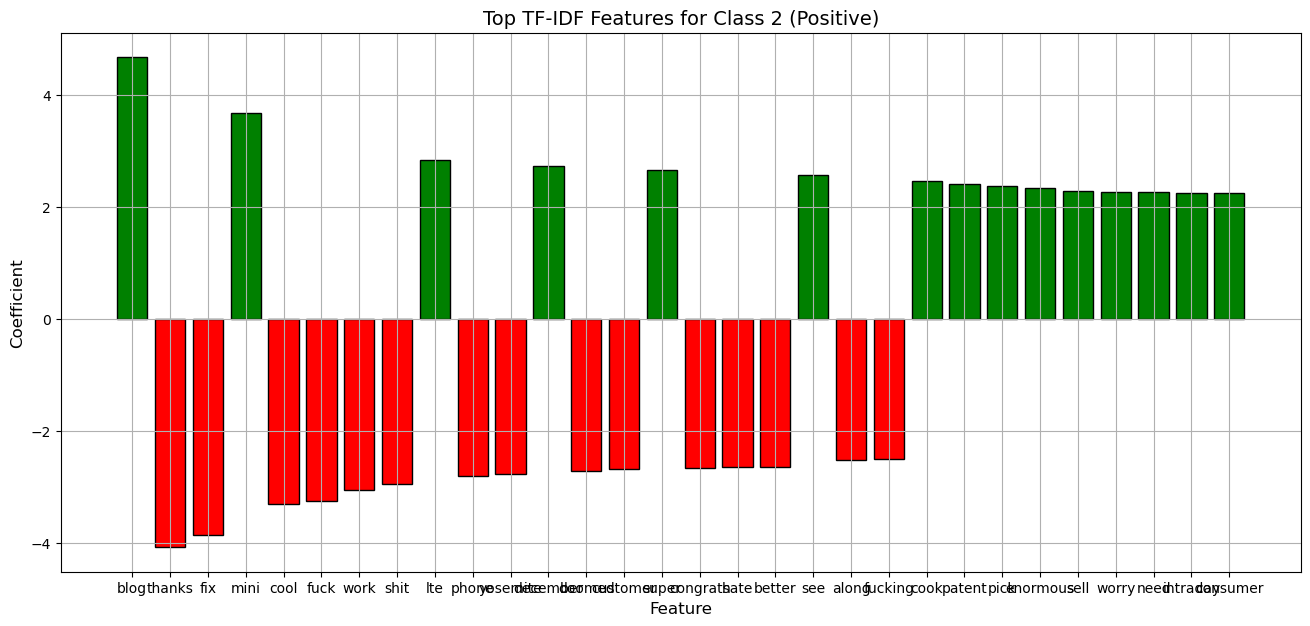

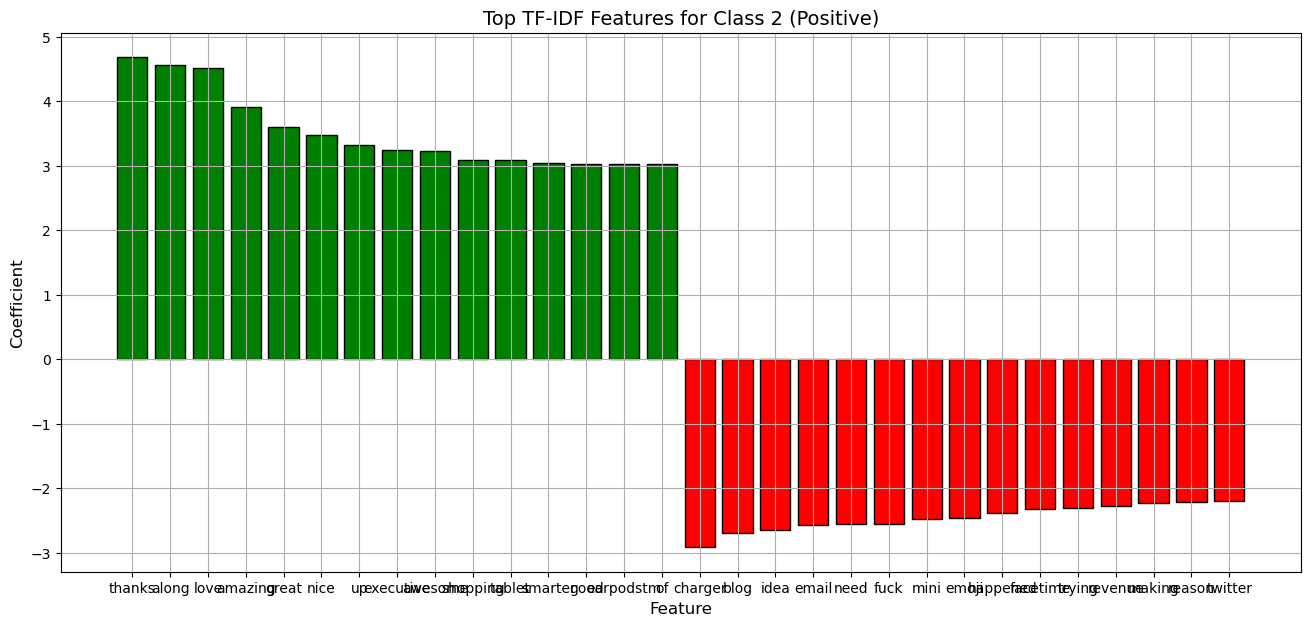

In [48]:
# Extract fitted TfidfVectorizer and classifier from the pipeline
vectorizer = best_models['LogisticRegression'].named_steps['tfidf']
classifier = best_models['LogisticRegression'].named_steps['clf']

# Get feature names and corresponding coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_  # shape: (n_classes, n_features)

# For multiclass, we analyze importance per class
n_classes = coefficients.shape[0]
top_n = 15  # Top features per class

# Plot top features per class
for class_index in range(n_classes):
    class_coef = coefficients[class_index]
    top_pos_indices = np.argsort(class_coef)[-top_n:]
    top_neg_indices = np.argsort(class_coef)[:top_n]

    top_features = pd.DataFrame({
        'Feature': feature_names[np.concatenate([top_neg_indices, top_pos_indices])],
        'Coefficient': class_coef[np.concatenate([top_neg_indices, top_pos_indices])]
    })

    top_features['Importance'] = top_features['Coefficient'].abs()
    top_features = top_features.sort_values(by='Importance', ascending=False)

    sentiment_label = {0: "Negative", 1: "Neutral", 2: "Positive"}[class_index]

    # Plot using your Plot class
    p = Plot()
    p.bar(
     x=top_features['Feature'],
     height=top_features['Coefficient'],
     title="Top TF-IDF Features for Class 2 (Positive)",
     xlabel="Feature",
     ylabel="Coefficient",
     color=['green' if c > 0 else 'red' for c in top_features['Coefficient']],
     figsize=(16, 7)
)



   



Words expressing **gratitude, excitement, and admiration** are highly weighted in favor of positive sentiment.
**Complaint-related terms**, vulgarities, or suggestions for improvement are negatively weighted.
These features can be used to understand what drives the model's prediction and are useful for refining both feature engineering and explainability in sentiment classification tasks.

### **Model Interpretation**

In this section, we apply the LimeTextExplainer to interpret our sentiment classification model by identifying the specific words in the input text that most strongly influenced the predicted sentiment. This enhances transparency by revealing the model’s decision-making process and helps assess the reliability and fairness of its predictions.

In [49]:
#! pip install lime

In [50]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Extract TF-IDF and classifier from the tuned pipeline
tuned_pipeline = best_models['LogisticRegression']
vectorizer = tuned_pipeline.named_steps['tfidf']
classifier = tuned_pipeline.named_steps['clf']

# Prepare the class names
class_names = ['Negative', 'Neutral', 'Positive']
# Define the prediction function for LIME
def predict_proba(texts):
    return classifier.predict_proba(vectorizer.transform(texts))

# Instantiate LIME text explainer
explainer = LimeTextExplainer(class_names=class_names)
# Pick an example from the test set
i = 15  # or any index you'd like to inspect
text_instance = X_test.iloc[i]
true_label = y_test.iloc[i]

print(f"Tweet: {text_instance}")
print(f"True Sentiment: {class_names[true_label]}")
# Generate explanation
exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)

# Visualize in notebook
exp.show_in_notebook(text=True)


Tweet: ubs increase sale revenue eps friday december
True Sentiment: Neutral


## **Saving the model**

To avoid retraining the model every time it is needed, we save the trained model using `joblib`. This allows us to persist the model to disk and reload it later for prediction or evaluation without repeating the training process.


In [51]:
import joblib
joblib.dump(tuned_logreg,"tweet_classifier.pkl")

['tweet_classifier.pkl']

## **6. Model Deployment**

In this section, we deploy our sentiment analysis model using a Streamlit app, providing a simple and interactive interface where users can input text and receive real-time sentiment predictions. Deploying the model in this way enables business teams, customer support agents, or product managers to access insights without requiring technical expertise—facilitating faster, data-driven decision-making and improving responsiveness to customer feedback.

In [52]:
import streamlit as st
import joblib
import re
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('stopwords')

# Load model (pipeline or preprocessed-compatible model)
model = joblib.load('tweet_classifier.pkl')  # Replace with your actual filename

# Preprocessing function for single tweet
def clean_tweet(tweet):
    wordLemm = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    tweet = str(tweet).lower()
    tweet = re.sub(urlPattern, ' ', tweet)
    tweet = re.sub(userPattern, ' ', tweet)
    tweet = re.sub(alphaPattern, " ", tweet)
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    words = []
    for word in tweet.split():
        if word not in stop_words and len(word) > 1:
            word = wordLemm.lemmatize(word)
            words.append(word)
    return " ".join(words)

# Streamlit UI
st.title("Sentiment Classification App")
st.write("This app predicts the sentiment of a tweet or short message. (0 = Negative, 1 = Neutral, 2 = Positive)")

# Input box
user_input = st.text_area("Enter your tweet or sentence below:")

# Predict button
if st.button("Predict Sentiment"):
    if user_input.strip() == "":
        st.warning("Please enter some text to classify.")
    else:
        cleaned = clean_tweet(user_input)
        prediction = model.predict([cleaned])[0]
        probas = model.predict_proba([cleaned])[0]

        st.markdown(f"### 🔍 Predicted Sentiment: **{prediction}**")
        st.write("#### Class Probabilities:")
        for i, prob in enumerate(probas):
            st.write(f"- Class {i}: {prob:.2f}")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-07-16 01:55:48.917 
  command:

    streamlit run c:\Users\HomePC\anaconda3.1\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


## **7 Recommendations**



#### *1. Deploy the Tuned Logistic Regression Model*
The tuned **Logistic Regression model**, trained on augmented data, demonstrated the most consistent and balanced performance:
- Highest **ROC AUC** (0.84) and strong **macro F1-score** (0.64).
- Maintained solid recall across all sentiment classes.
- Offers simplicity, interpretability, and stability — ideal for production environments where transparency is critical (e.g., compliance and auditability).


#### *2.  Regularly retrain the model with updated tweets*
Language and sentiment expression on social media platforms evolve quickly, risking model obsolescence over time.


#### *3. Explore Advanced Models for Future Gains*
Although Logistic Regression performed well, advanced NLP models like **BERT** or **RoBERTa** could offer deeper semantic understanding, especially as language complexity increases.
.

#### *4. Target Strategic Business Applications*
Use sentiment analysis results to drive actionable outcomes:
- Monitor brand sentiment (e.g., Apple) in real-time.
- Flag urgent customer feedback for **support prioritization**.
- Evaluate **marketing campaign performance** based on sentiment shifts.




## **8 Limitations and Assumptions**



#### *1. Assumption of Text Representations*
The project assumes that **TF-IDF vectorization** captures the most relevant and discriminative information from tweets. While TF-IDF is effective for keyword-level features, it may not fully represent **semantic meaning** or **contextual dependencies** found in more complex sentences.


#### *2. Quality and Bias in Augmented Data*
Augmentation was applied to address **class imbalance**, particularly for the underrepresented positive sentiment class. However:
- The quality of augmented text relies on `nlpaug`, which may generate semantically shallow or noisy samples.
- Over-augmentation or poor augmentation may introduce **bias** or **noise**, potentially leading to overfitting or misclassification.


#### *3. Class Imbalance Challenge*
Despite text augmentation, **class 2 (positive sentiment)** remains challenging to predict with high precision. The models tend to favor the majority classes, and any changes in class distribution in production data could impact performance.



#### *4. Model Simplicity vs. Expressiveness*
Logistic Regression was selected for its interpretability and robustness. However, it may underperform in scenarios requiring **deep linguistic understanding** compared to transformer-based models like BERT.



#### *5. Assumption of Data Stationarity*
The model assumes that the **language and sentiment patterns** in the training data are representative of future Twitter content. However, trends, slang, and sentiment expressions evolve rapidly on social media.



#### *6. Noise in Social Media Data*
Twitter data can be noisy, containing:
- Misspellings
- Emojis
- Hashtags
- Irregular grammar or informal language

While basic cleaning was applied, these irregularities may still affect prediction quality.


#### *7. Subjectivity in Sentiment Labels*
The sentiment labels (negative, neutral, positive) may not always capture the full nuance or intent of the tweet. Sentiment is **subjective**, and ground truth labeling may include **human error** or **annotator bias**.

